# Reviewing Neural Networks in Pytorch

### Introduction

So we've now learned the main components of neural networks.  In this lesson, we'll use Pytorch to train a neural network that detects images.  And use that an opportunity to review concepts we learned, and how they are applied in Pytorch.

## 0. Setting up our Environment

Ok, so as a first step, let's again speed things up by having colab use the GPU, instead of the CPU it's currently using.  

> Again don't need to understand why this is faster -- just know doing this now will save some time later on.

To make the switch, go to the menu bar in Google colab, and click on `Runtime` and then click on `change runtime type` as shown below.

> <img src="./change_runtime_type.png" width="30%">

From there, change the runtime type to GPU, and click on `Save` as seen below.

> <img src="./to_gpu.png" width="40%">

Ok, our environment is now in good shape and it's time to move on.

## 1. Acquire the Data

So once again, as our first step, we'll need to download our data, which we can do by pressing `shift + return` on the cell below.

In [1]:
import tensorflow.keras as keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

Now let's take a look at our data.

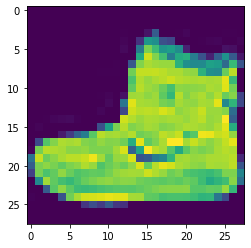

In [2]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

Ok, so each element in `X_train` above contains the pixels of a separate image.  And remember that really each observation consists of a matrix of pixels.

In [3]:
X_train[0].shape

(28, 28)

And each value in the matrix represents the grayscale pixel value.

In [7]:
X_train[0][:5, :5]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

Now that covers the observations but what about the labels?  Here, the labels are again numbers, and each number corresponds to a different article of clothing. 

In [8]:
fashion_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

So remember our first observation was a boot, and if we look at the first labels.

In [9]:
y_train[:3]

array([9, 0, 0], dtype=uint8)

We see that the label corresponds to an ankle boot.

## 2. Format and Reshape the Data

#### A. Converting the data

Ok, now to ultimately pass our data through our neural network, we'll need to convert our data to the correct format.  First, we need our `X_train` data to be a tensor, and will need the datatype to be a `float`.

In [10]:
import torch

X_train_tensor = torch.tensor(X_train).float()

We also need to convert our `y_train` data to be of type tensor, but will need that to be of type `long`.

> Long is Pytorch's version of an integer.

In [72]:
y_train_tensor = torch.tensor(y_train).float()

#### B. Reshaping our Data

Now that our data is of the correct type, we'll still need to reshape the `X_train_tensor` data.  Currently, our tensor has the following shape:

In [12]:
X_train_tensor.shape

torch.Size([60000, 28, 28])

So we have 60,000 observations, where each observation is a $28x28$ grid.  But remember that our neural network starts with a linear linear layer, where we'll matrix algebra like so:

> $z(x) = x \cdot W + b =  w_1x_1 + w_2x_2 ... w_nx_n + b $

So we'll need each observation $x$ to be a vector that we can then dot with $W$, our weight matrix.  So, we'll change each observation from a matrix to a list of vectors with the following:

In [13]:
X_train_reshaped = X_train_tensor.view(60000, -1)

> So with the `view` function above we specified our data to only be in two dimensions, and letting Pytorch calculate the length of each vector with the `-1`, we were able to reshape our data into a list of vectors each of length 784.

In [14]:
X_train_reshaped.shape

torch.Size([60000, 784])

Ok, with that, our data should be good to pass through the hypothesis function of our neural network.  Let's build our neural network.

### 3. Building our Neural Network

Ok, so now it's time to construct our neural network.  Mathematically, our neural network will look like the following:

$z_{1x64} = x_{1x784} \cdot W_{784x64} + b_{1x64}$

$a_{1x64} = \sigma(z_{1x64})$

$z_{1x10} = a_{1x64} \cdot W_{64x10} + b_{1x10}$

$a_{1x10} = \frac{e^z}{\sum e^z}$ 

> Take a second to see if you can explain the above -- considering the input and output of each layer.  So if we pass through a vector of length 784, we then need each neuron in our first weight matrix to have length 784.  With 64 columns -- one for each neuron -- means that the output will be of length 784, as each neuron's linear function returns a separate output. 

> Then skipping to our last layer, we see our softmax function.  The softmax funtion exaggerates larger predictions, and divides by the total to turn a prediction into a probability.

In Pytorch, we can construct the above neural network with the following:

In [25]:
import torch.nn as nn

torch.manual_seed(5)

net = nn.Sequential(
    nn.Linear(784, 64),
    nn.Sigmoid(),
    nn.Linear(64, 10),
    nn.Softmax(dim = 0)
)

net

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=64, out_features=10, bias=True)
  (3): Softmax(dim=0)
)

### Making a Prediction

Ok, so we just created a neural network that will take in our tensors representing images.  Now before we train this neural network, let's make sure we undertand how it will predict what each image is.  We can see this by selecting our first image and passing it into our neural network.

> Below, we select our first image.

In [26]:
first_img = X_train_reshaped[0]

> Remember that this is just one long tensor -- a vector with each of the 784 pixels of our image.

In [27]:
first_img.shape

torch.Size([784])

And when we pass it into our neural network, we get the following vector -- outputted from our softmax function:

In [28]:
pred = net(first_img)

pred

tensor([0.0856, 0.0598, 0.0718, 0.0658, 0.0893, 0.0782, 0.1680, 0.1161, 0.1007,
        0.1648], grad_fn=<SoftmaxBackward>)

So we outputted a tensor of length 10, where each entry represents the predicted likelihood of the observation being any of the articles of clothing.  

> And if we want to quickly see the what the neural network predicts as the correct label -- based on which element with the highest probability -- we can use the argmax function.

In [29]:
torch.argmax(pred)

tensor(6)

> So above, our neural network believes that the number 6 is most likely -- as that has the highest probability, with a `.1680`.

## 4. Training our Neural Network

Ok, so we've formatted our data, and defined our neural network.  Of course, we still need to train the parameters of our neural network.  Once again we do this with gradient descent where we repeatedly find the partial derivative with respect to each of the parameters in the function. 

Just like we saw in previous lessons, we do this by first accomplishing forward propagation, where our neural network calculates the output at each individual layer. 

>  With Pytorch, we do this simply by passing our data through our neural network and getting a prediction.

In [46]:
y_hat = net(first_img)

And then we perform backpropagation by calling the backward function.  

Because we want to see how a change in the parameters affects the cost of our function to do this we should first initialize our loss function.  We'll stick with mean squared error as our loss function:

* $ J(\hat{y}, y) = \sum  (y - \hat{y})^2 $

Which we can load from Pytorch:

In [70]:
import torch.optim as optim

criterion = nn.MSELoss()

opt = optim.Adam(net.parameters(), lr=0.0005)

In [73]:
loss = criterion(y_hat[y_train_tensor[:1].long()], y_train_tensor[:1].float())

In [55]:
loss.backward()

And from there, we can see that this calculated how a nudge in any of our parameters would affect the output of our cost function.

In [68]:
net[2].weight.grad[:5, :5]

tensor([[0.0000e+00, 0.0000e+00, 1.0341e-15, 2.4928e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.2218e-16, 1.7408e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 8.6773e-16, 2.0917e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.9432e-16, 1.9147e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0791e-15, 2.6013e-01, 0.0000e+00]])

And it uses backpropagation, where it moves backward through the each layer, to perform this calculation.  Once these gradients are calculated we then update all of our parameters by the negative gradient multiplied by our learning rate.

In [71]:
opt.step()

So those are our steps:

```python
y_hat = net(X_tensor)             # 1. Forward Prop: predict, and get the output at each layer
loss = criterion(y_hat, y_tensor) # 2. See how off the prediction is according to the cost function
loss.backward()                   # 3. Backward Prop: Calculate the gradient for parameters
opt.step()                        # 4. Update parameters by: theta = theta -  learning_rate*gradient 
```

We repeat these steps to descend our cost curve.

<img src="./cost-curve-slopes.png" width="40%">

### 5. Putting it All Together

Ok, now that we reviewed all of the above -- let's quickly go through all of the steps of creating a neural network.  

1. Format the data

We format and reshape the data with the following:

In [74]:
X_train_tensor = torch.tensor(X_train).float().view(60000, -1)

y_train_tensor = torch.tensor(y_train).float().view(60000, -1)

And to get the data to run on the GPU that we set up earlier we then call the oddly named `cuda` function.

In [ ]:
X_train_tensor_gpu = X_train_tensor.cuda()

y_train_tensor_gpu = y_train_tensor.cuda()

> If you have not enabled gpu on google colab, you will see an error below.  You can fix this by going through step 0 up top, or you can just ignore it, and training will simply take more time.

2. Define the neural network

Then we define our neural network with the following:

In [25]:
import torch.nn as nn

torch.manual_seed(5)

net = nn.Sequential(
    nn.Linear(784, 64),
    nn.Sigmoid(),
    nn.Linear(64, 10),
    nn.Softmax(dim = 1)
)

net

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=64, out_features=10, bias=True)
  (3): Softmax(dim=0)
)

And we also need to call cuda on our neural network itself -- as our neural network is made up of weight matrices and bias vectors which are tensors.

In [62]:
net.cuda()

3. Train the neural network

To train the neural network, let's again initialize our loss function, and the optimizer.

In [76]:
import torch.optim as optim
import torch.nn as nn

x_loss = nn.CrossEntropyLoss()
adam = optim.Adam(net.parameters(), lr=0.0002)

And finally, let's loop through the data applying the training steps that we saw before.

> Press shift + return.  If you see the a little green arrow towards the left of the cell below, you know that the code is working.  While you wait keep reading below.

In [78]:
for epoch in range(3):
    for (x, y) in zip(X_train_tensor_gpu, y_train_tensor_gpu):
        net.zero_grad()  
        X_reshaped = x.view(-1,28*28) # change image from grid to a list
        prediction = net(X_reshaped) # make prediction
        y_hat = prediction.view(-1)[y.long()]
        loss = x_loss(y_hat, y.float()) # calculate loss
        loss.backward() # determine how to update the neural network
        adam.step() # make the update
    print(loss)

### While you wait

1. Reviewing our test data

Now remember that what's occurring above is that we are training our neural network by showing showing our neural network both the observations, and then the answers.  But we still need to make sure that our neural network performs well on data it's never seen before.  After all, perhaps it only learned how to detect those particular images in the training set -- but not images of clothing in general.   

We want to make sure our machine learning model *generalizes* to perform well on unseen data, and that we have not overfit the model to our training data.  

We check for overfitting by holding back a portion of our data -- called our test data -- and have our neural network make predictions on these observations that it's never seen before.  If it performs well on the test data, which it's never seen before, then we'll be more confident it can identify similar photos it's never seen before.

Lucky for us, we've already loaded up this test data at the top.

```python
import tensorflow.keras as keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
```

### 6. Evaluating our Neural Network

Ok, so if our neural network has finished training, it's time to move on and see how well our neural network is working.  

As we just explained, we don't want to use the same images we used to train our neural network -- our neural network has already seen these observations, as well as the answers.  Instead, we want to see how well our neural network performs on some images that it hasn't yet seen -- our test set.  To use the data in our test set, we first need to convert `X_test` into a tensor. 

In [64]:
X_test_gpu = torch.tensor(X_test).view(-1, 28*28).float().cuda()

And then we can see how well it performed with the first image.

In [126]:
predictions_test = net(X_test_gpu)

In [127]:
torch.argmax(predictions_test[:1], dim = 1)

# 7

tensor([[1.8848e-12, 2.2202e-16, 4.5645e-16, 1.6148e-15, 1.4248e-14, 4.9672e-02,
         3.9909e-13, 7.0305e-01, 8.7145e-04, 2.4641e-01]],
       grad_fn=<ExpBackward>)

Which looks like a good prediction.

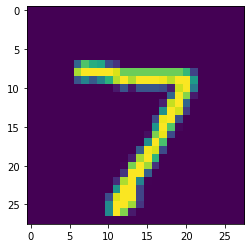

In [65]:
plt.imshow(X_test[0])

And then we can get the predictions for the entire test set by passing the predictions into the `argmax` function.

In [128]:
hard_predictions = torch.argmax(predictions_test, axis = 1)

And we can eyeball how well our first predictions match up with the labels. 

In [129]:
hard_predictions[:10]

tensor([7, 2, 1, 1, 2, 1, 2, 2, 8, 7])

In [130]:
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

Looking good so far.  Or we can see the percentage that it that it predicted correctly, by using the `accuracy_score` method from sklearn.

In [1]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, hard_predictions.cpu())

# 0.8881

So the output above is the percentage of our test set that it predicted correctly.  Not too bad for our first neural network.  If it's above .85 or so, that's not too bad.

### Summary

In this lesson, we trained a neural network in Pytorch.  Nice work!!  At this point, you should feel pretty good about the hypothesis function of a neural network, and somewhat ok about the training of a neural network.  In the next set of lessons we'll go deeper into training.  If you plan on working with neural networks in the future, this knowledge is pretty essential.  You'll need it to understand the fundamentals of neural networks, so that you can diagnose how neural networks can go wrong, as well as some of the developments in neural networks to remedy these issues.

### Resources

[Colab Deep Learning](https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=d44TznbgZZgm)

[Log Softmax](https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation)

[Minibatches](https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way)